In [32]:
import sys
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import logging

from math import sqrt
from prophet import Prophet
from pmdarima import auto_arima
from xgboost import XGBRegressor
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.utils import util as utl
from itertools import combinations, permutations, product
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

global companies_set 

warnings.filterwarnings('ignore')

# 1 - Estudo de auto regressão dos mercados

## 1.1 - Preparação dos datasets com os valores totais de cada mercado

In [33]:
door_dir = glob.glob(r"D:\Documentos_D\UFCG\2021.2e\TCC\Project\analise_de_indicador_tcc_ufcg\data\processed\**\*" + ".csv", recursive=True)

df = pd.DataFrame()

for file_path in door_dir:
    temp_df = pd.read_csv(file_path)
    df = df.append(temp_df)

df = df.reset_index().drop(['index'], axis=1)
df['Volume_Venda'] = df['Volume_Venda'].round(2)

In [34]:
dfm = pd.DataFrame()
temp_df = df[((df.Mercado == 'AN') & (df.Empresa == 'E2'))].reset_index().drop(['index'],axis=1)

dfm['Data'] = temp_df.Data
dfm['Data'] = pd.to_datetime(dfm.Data)
# ----------------------------------------------------AN:
r1_bc = df[((df.Mercado == 'AN') & (df.Empresa == 'E1'))].Volume_Venda.astype(float).to_frame()
r1_br = df[((df.Mercado == 'AN') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

dfm['AN'] = r1_bc.add(r1_br,axis=0)

# ----------------------------------------------------AS:
r2_bi = df[((df.Mercado == 'AS') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r2_br = df[((df.Mercado == 'AS') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

r2_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r2_bt_temp['Volume_Venda'] = values
r2_bt = df[((df.Mercado == 'AS') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r2_bt = r2_bt.append(r2_bt_temp).reset_index().drop(['index'], axis=1)

dfm['AS'] = r2_bi.add(r2_br,axis=0)
dfm['AS'] = dfm['AS'] + r2_bt['Volume_Venda']

# ----------------------------------------------------EU:
r3_bi = df[((df.Mercado == 'EU') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r3_br = df[((df.Mercado == 'EU') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

dfm['EU'] = r3_bi.add(r3_br,axis=0)

# ----------------------------------------------------AL:
r4_br_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(13):
    values.append(0)
r4_br_temp['Volume_Venda'] = values
r4_br = df[((df.Mercado == 'AL') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r4_br = r4_br.append(r4_br_temp).reset_index().drop(['index'], axis=1)

r4_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r4_bt_temp['Volume_Venda'] = values
r4_bt = df[((df.Mercado == 'AL') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r4_bt = r4_bt.append(r4_bt_temp).reset_index().drop(['index'], axis=1)

dfm['AL'] = r4_br.add(r4_bt,axis=0)

# ----------------------------------------------------JP:
r5_bi_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(56):
    values.append(0)
r5_bi_temp ['Volume_Venda'] = values
r5_bi = df[((df.Mercado == 'JP') & (df.Empresa == 'E3'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r5_bi = r5_bi_temp.append(r5_bi).reset_index().drop(['index'], axis=1)

r5_br = df[((df.Mercado == 'JP') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)

r5_bt_temp = pd.DataFrame(columns=['Volume_Venda'])
values = []
for i in range(18):
    values.append(0)
r5_bt_temp ['Volume_Venda'] = values
r5_bt = df[((df.Mercado == 'JP') & (df.Empresa == 'E4'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
r5_bt = r5_bt.append(r5_bt_temp ).reset_index().drop(['index'], axis=1)

dfm['JP'] = r5_bi.add(r5_br, axis=0)
dfm['JP'] = dfm['JP'] + r5_bt['Volume_Venda']

# ----------------------------------------------------BRL:
r6_br = df[((df.Mercado == 'BRL') & (df.Empresa == 'E2'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
dfm['BRL'] = r6_br

# ----------------------------------------------------Indefinido:
indefinido = df[((df.Mercado == 'Indefinido'))].Volume_Venda.reset_index().drop(['index'], axis=1).astype(float)
dfm['Indefinido'] = indefinido

dfm = dfm.set_index('Data')

display(dfm.head(5))

,AN,AS,EU,AL,JP,BRL,Indefinido
Data,,,,,,,
2012-01-01,9498.0,27964.0,91330.0,1638.0,38716.0,4598.0,83690.0
2012-02-01,22596.0,26910.0,75416.0,1248.0,59352.0,4192.0,92190.0
2012-03-01,23424.0,67078.0,77030.0,1742.0,52372.0,4664.0,111940.0
2012-04-01,21276.0,12912.0,78790.0,1118.0,0.0,4584.0,53454.0
2012-05-01,22946.0,36676.0,64634.0,2704.0,98688.0,4754.0,115438.0


In [35]:
markets_names = ['AN','AS','EU','AL','JP','BRL'] # O mercado 'Indefinido' será desconsiderado, a partir deste momento;
markets_values = []
for market_name in markets_names:  
    values_market_df = dfm[market_name]
    markets_values.append(values_market_df.to_frame())

In [36]:
# Criando  volume de dados para treinamento do mercado da América Latina ('AL'), à parte:
date_indexes = []
sales_values = []

for market_values_df, market_name in zip(markets_values, markets_names):
    if market_name in ['AL']:
        temp_df =  market_values_df
        for i, row in temp_df.iterrows():
            date = i
            value = row['AL']

            if date < pd.Timestamp('2016-01-01'): # Coletando valores até 01/12/2015;
                date_indexes.append(i)
                sales_values.append(value)

df_AL = pd.DataFrame()
df_AL['Data'] =  date_indexes
df_AL['AL'] =  sales_values
df_AL = df_AL.set_index('Data')
markets_values[3] = df_AL

## 1.2 - Teste de Estacionariedade

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

p_values = []

# Verificando estacionariedade com adfuller:
for market_values_df, market_name in zip(markets_values, markets_names):
    series = market_values_df
    X = series.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    result = adfuller(train, autolag='AIC')
    p_values.append((market_name,np.round(result[0],4),np.round(result[1],4)))

print(p_values)

[('AN', -2.2539, 0.1873), ('AS', -1.2533, 0.6503), ('EU', -9.579, 0.0), ('AL', -4.8412, 0.0), ('JP', -6.4335, 0.0), ('BRL', -0.9724, 0.7632)]


## 1.3 - Uso da biblioteca AutoARIMA para verificação dos melhores parâmetros de ARIMA para os mercados

In [38]:
best_params_arima = []
for market_values_df, market_name in zip(markets_values, markets_names):
    print("Mercado: ", market_name)
    X = market_values_df.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    res = auto_arima(train, start_P=0, start_q=0, stepwise=True, trace=True, display=0)
    best_params_arima .append((market_name, res))

Mercado:  AN
Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2176.167, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2227.275, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2196.612, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2160.338, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2225.319, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2161.701, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2161.651, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2160.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2161.189, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2162.794, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2194.726, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.191 seconds
Mercado:  AS
Perfor

In [39]:
print("melhores parâmetros para o ARIMA para a série temporal dos volumes de vendas de cada mercado:")
for p in best_params_arima:
    print("Mercado: %s | Parâmetros ARIMA (p,d,q): %s" % (p[0], str(p[1])))

melhores parâmetros para o ARIMA para a série temporal dos volumes de vendas de cada mercado:
Mercado: AN | Parâmetros ARIMA (p,d,q):  ARIMA(0,1,1)(0,0,0)[0]          
Mercado: AS | Parâmetros ARIMA (p,d,q):  ARIMA(0,1,2)(0,0,0)[0]          
Mercado: EU | Parâmetros ARIMA (p,d,q):  ARIMA(0,1,1)(0,0,0)[0]          
Mercado: AL | Parâmetros ARIMA (p,d,q):  ARIMA(0,0,0)(0,0,0)[0] intercept
Mercado: JP | Parâmetros ARIMA (p,d,q):  ARIMA(2,0,0)(0,0,0)[0] intercept
Mercado: BRL | Parâmetros ARIMA (p,d,q):  ARIMA(0,1,1)(0,0,0)[0]          


## 1.4 - Análise de autocorrelação e autocorrelação parcial das séries temporrais

Mercado:  AN


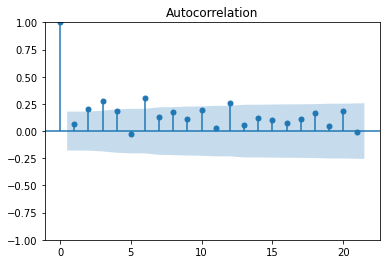

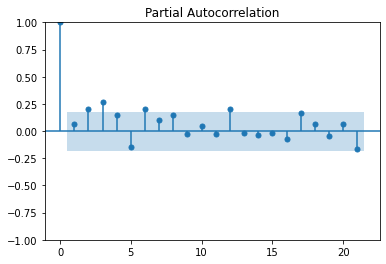

Mercado:  AS


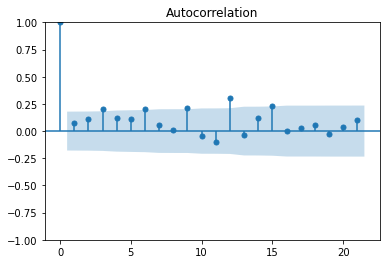

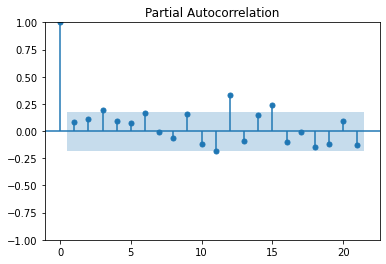

Mercado:  EU


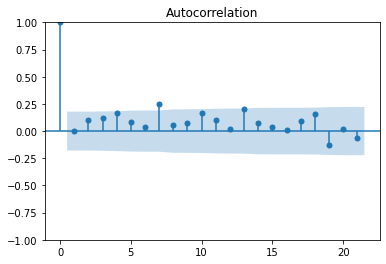

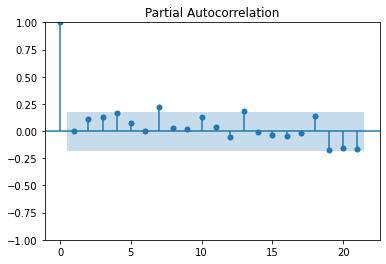

Mercado:  AL


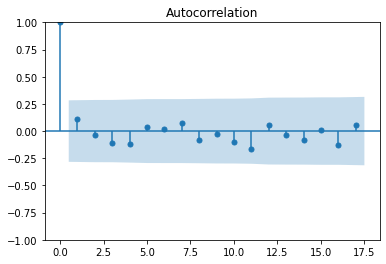

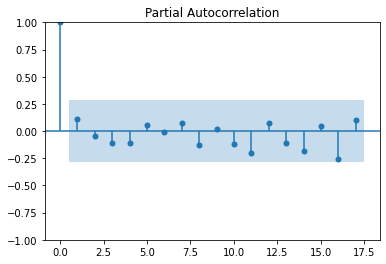

Mercado:  JP


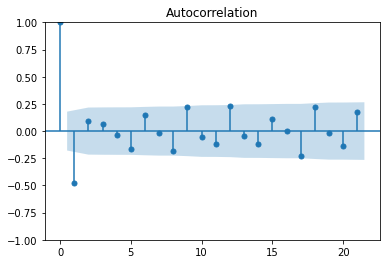

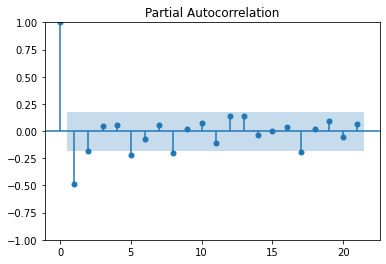

Mercado:  BRL


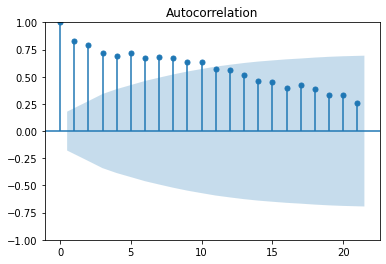

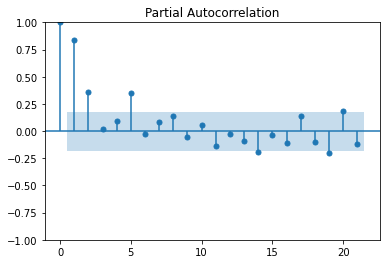

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Correlograma de autocorrelação:
for market_values_df, market_name in zip(markets_values, markets_names):
    print("Mercado: ", market_name)
    X = market_values_df.values
    plot_acf(X)
    plot_pacf(X)
    plt.show()

## 1.4 - Execução do modelo de auto regressão Autoreg

In [42]:
from statsmodels.tsa.ar_model import AutoReg

summary = []

for market_values_df, market_name in zip(markets_values, markets_names): 
    # Separando o dataset entre treino e teste:
    series = market_values_df
    X = series.values
    train, test = X[1:len(X)-12], X[len(X)-12:]
    out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
    
    model = AutoReg(train, lags = 6)
    res = model.fit()
    cparams = res.params

    predictions = res.predict(start=len(train), end=len(train)+len(test)-1)
    
    mae = mean_absolute_error(test, predictions)
    r2_scr = r2_score(test, predictions)
    
    summary.append((market_name, r2_scr, mae))

print(summary)

[('AN', -0.9703979881003668, 7301.322914424768), ('AS', -0.5398964367070516, 24410.759317946824), ('EU', -0.03645641309704173, 13728.743117201453), ('AL', 0.03818805283410609, 987.7036932610464), ('JP', -0.009994096772768968, 10010.27770044319), ('BRL', -0.26776087773352875, 491.3353605103209)]


## 1.5 - Execução do modelo de auto regressão ARIMA

### 1.5.1 - Execução do modelo de auto regressão ARIMA com os parâmetros sugeriso pelo autoARIMA

In [43]:
# Preparaçao dos melhores parametros sugeridos pelo autoARIMA:
orders = []
for p in best_params_arima:
    split_list = str(p[1]).split('(')
    split_list = split_list[1].split(')')

    temp_triple = []
    for c in split_list[0]:
        if c != ',':
            temp_triple.append(int(c))
    orders.append(tuple(temp_triple))

# Os parametros para o mercado AL serão removidos:
if len(orders) > 5:
    orders.pop(3)

print("Melhores parâmetros ordernados para cada mercado, sem considerar o mercado 'AL':")
print(orders)

Melhores parâmetros ordernados para cada mercado, sem considerar o mercado 'AL':
[(0, 1, 1), (0, 1, 2), (0, 1, 1), (2, 0, 0), (0, 1, 1)]


In [48]:
import copy
from statsmodels.tsa.arima.model import ARIMA

i = 0

markets_names_no_AL = copy.deepcopy(markets_names)
markets_values_no_AL = copy.deepcopy(markets_values)

if len(markets_names_no_AL) == 6:
    markets_names_no_AL.remove("AL")

if len(markets_values_no_AL) == 6:
   markets_values_no_AL.pop(3)

results_arima = {}
for market_values_df, market_name, ord in zip(markets_values_no_AL, markets_names_no_AL, orders):
    print("mercado: ", market_name)
    print("parametros: ", ord)
    X = market_values_df[market_name]
    train, test = X[1:len(X)-12], X[len(X)-12:]

    model = ARIMA(train, order=ord)
    res = model.fit()

    predictions = res.predict(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-01'), dynamic=False)
    mae = mean_absolute_error(test, predictions)
    r2_scr = r2_score(test, predictions)
    results_arima[market_name] = (r2_scr,mae)
    

    print(market_name+" finalizado!")

print('\n')
print("Resultados do ARIMA:")
for key in results_arima.keys():
    metrics = results_arima[key]
    print("Mercado: "+ key + ' | r²: ' + str(metrics[0]) + ', '+ ' mae: '+ str(metrics[1]))

mercado:  AN
parametros:  (0, 1, 1)
AN finalizado!
mercado:  AS
parametros:  (0, 1, 2)
AS finalizado!
mercado:  EU
parametros:  (0, 1, 1)
EU finalizado!
mercado:  JP
parametros:  (2, 0, 0)
JP finalizado!
mercado:  BRL
parametros:  (0, 1, 1)
BRL finalizado!


Resultados do ARIMA:
Mercado: AN | r²: -0.14846933668511997,  mae: 5075.311484028306
Mercado: AS | r²: -1.1107447004191346,  mae: 29107.38744698946
Mercado: EU | r²: -0.18658717616962917,  mae: 15273.866014712568
Mercado: JP | r²: -0.09212324541459749,  mae: 9911.831483343527
Mercado: BRL | r²: -0.4928280710548354,  mae: 489.73084755913993


### 1.5.2 - Execução do modelo de auto regressão ARIMA com combinação de varios parametros de AR, MA e ARMA:

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Criação de lista com combinações, para teste de ordens (p,d,q) no ARIMA. Obteve-se apenas as triplas com o valor d = 0:
orders = []
for ord in product([0,1,2,3,6,12], repeat = 3):
    if ord[1] != 0:
        orders.append(ord)
        
i = 0
results_arima = {}
for market_values_df, market_name in zip(markets_values, markets_names):
    if market_name != 'AL':
        print("mercado: ", market_name)
        X = market_values_df[market_name]
        train, test = X[1:len(X)-12], X[len(X)-12:]

        ords_arima = []
        for ord in orders:
            model = ARIMA(train, order=ord)
            
            try:
                res = model.fit()
                # predictions = res.predict(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-01'), dynamic=False)
                predictions = res.predict(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2021-12-01'), dynamic=False)
            except:
                pass

            mae = mean_absolute_error(test, predictions)
            # maes_arima.append(mae)

            r2_scr = r2_score(test, predictions)
            # r2s_arima.append(r2_scr)

            ords_arima.append((ord, r2_scr, mae))
        
        print(market_name+" finalizado!")

        results_arima[market_name] = ords_arima

print('\n')
print("Melhores resultados do ARIMA:")
# Coletando os melhores resultados do ARIMA para cada mercado, com o respectivo parâmetro utilizado:   
res_arima = []
for key in results_arima.keys():
    temp_order = []
    temp_r2 = []
    temp_mae = []
    for tpl in results_arima[key]:
        order = tpl[0]
        r2 = tpl[1]
        mae = tpl[2]

        temp_order.append(order)
        temp_r2.append(r2)
        temp_mae.append(mae)

    max_pos = temp_r2.index(max(temp_r2))
    res_arima.append((key, temp_order[max_pos], temp_r2[max_pos], temp_mae[max_pos]))

print(res_arima)

mercado:  AN
AN finalizado!
mercado:  AS
AS finalizado!
mercado:  EU
EU finalizado!
mercado:  JP
JP finalizado!
mercado:  BRL
BRL finalizado!


Melhores resultados do ARIMA:
[('AN', (0, 3, 6), 0.19585896860971286, 4386.10570358188), ('AS', (0, 1, 12), -0.3564727687977507, 23318.539712673406), ('EU', (1, 1, 0), -0.00885384566275249, 13494.494137196356), ('JP', (12, 3, 2), 0.1930562739059032, 7899.402446270479), ('BRL', (0, 1, 3), -0.38388790839460607, 479.81303404962426)]


## 1.6 - Execução do modelo de regressão XGBoostRegressor

In [54]:
def train_test_split(data,perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

def xgb_predict(train, val, model):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]

    model.fit(X,y)

    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

def validate(data, perc, model):
    predictions = []
    train, test = train_test_split(data, perc)

    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]

        pred = xgb_predict(history, test_X[0], model)
        predictions.append(pred)

        history.append(test[i]) # Histórico, para ir atualizando o treino com os valores mais novos;
    
    error_rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    error_mae = mean_absolute_error(test[:, -1], predictions)
    return error_rmse, error_mae, test[:, -1], predictions

In [55]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

for market_values_df, market_name in zip(markets_values, markets_names):

    market_values_df_copy =  market_values_df.copy(deep=True)
    market_values_df_copy['target'] = market_values_df_copy[market_name].shift(-1)
    market_values_df_copy.dropna(inplace=True)

    if market_name != 'AL':
        perc = 0.1
    else:
        perc = 0.25

    rmse, mae,  y, pred = validate(market_values_df_copy, perc, model)

    r2_scr = r2_score(y, pred)

    print("Mercado: ", market_name)
    print("r² score: ", r2_scr)
    print("MAE: ", mae)
    print("RMSE: ", rmse)

Mercado:  AN
r² score:  -3.062482440690557
MAE:  10510.994466145834
RMSE:  12386.455325255818
Mercado:  AS
r² score:  -0.6162161728671776
MAE:  22987.490397135418
RMSE:  28739.468100020986
Mercado:  EU
r² score:  -2.200811984843575
MAE:  21947.629557291668
RMSE:  27618.622749891925
Mercado:  AL
r² score:  -1.7517499312243827
MAE:  1746.5826791508782
RMSE:  2144.803201292788
Mercado:  JP
r² score:  -2.5598834925773053
MAE:  16374.654615647936
RMSE:  20960.924622577553
Mercado:  BRL
r² score:  -0.3799386819021131
MAE:  465.58217366536456
RMSE:  675.2328537819149


## 1.7 - Execução das predições para os anos sem dados históricos (2016 e 2022) com o prophet

21:35:05 - cmdstanpy - INFO - Chain [1] start processing
21:35:06 - cmdstanpy - INFO - Chain [1] done processing


AN


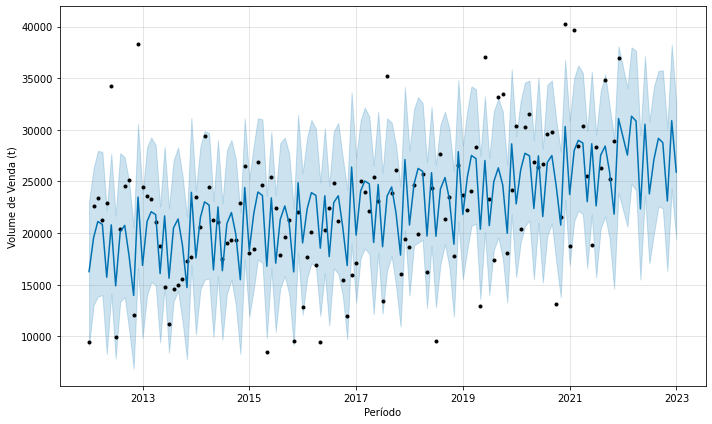

21:35:08 - cmdstanpy - INFO - Chain [1] start processing
21:35:08 - cmdstanpy - INFO - Chain [1] done processing


AS


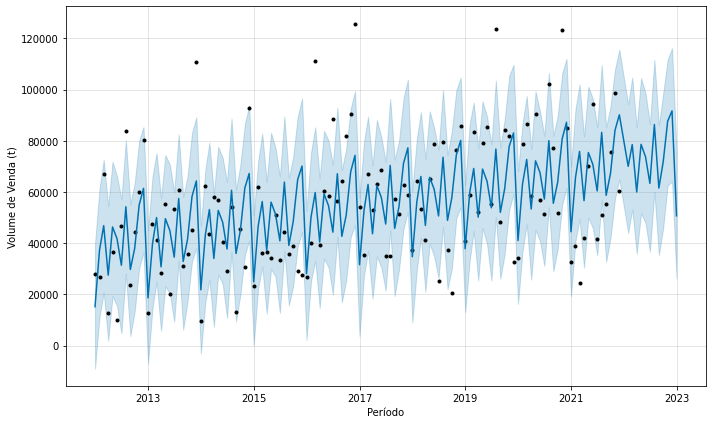

21:35:09 - cmdstanpy - INFO - Chain [1] start processing
21:35:09 - cmdstanpy - INFO - Chain [1] done processing


EU


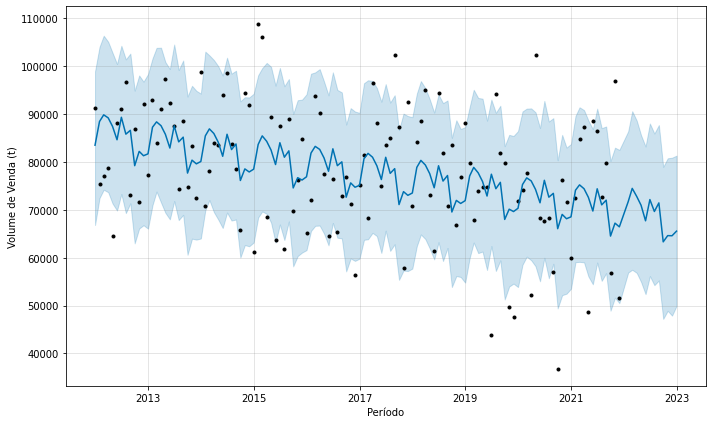

21:35:11 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing


AL


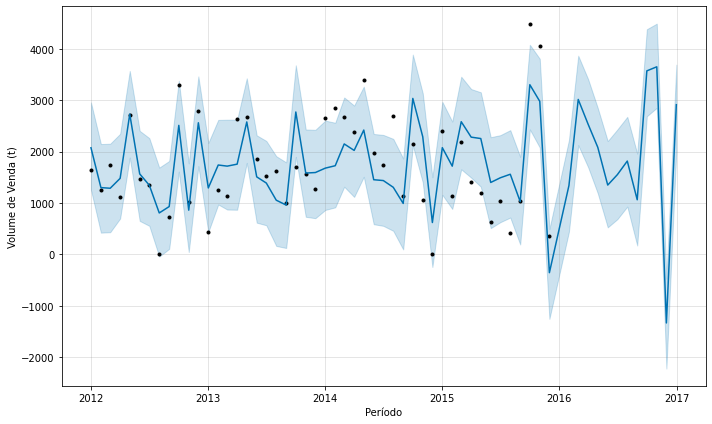

21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing


JP


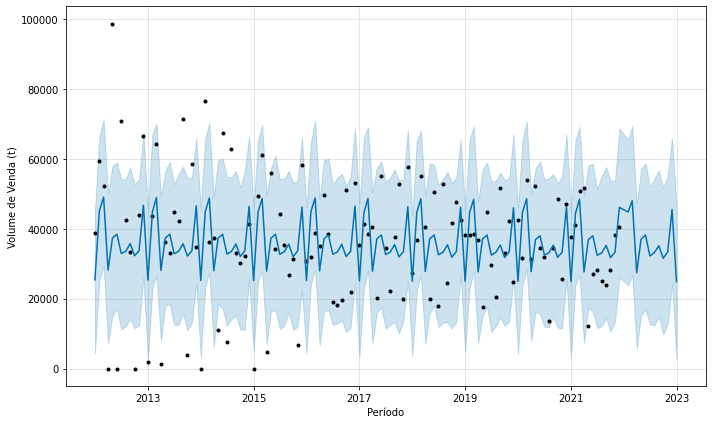

21:35:14 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing


BRL


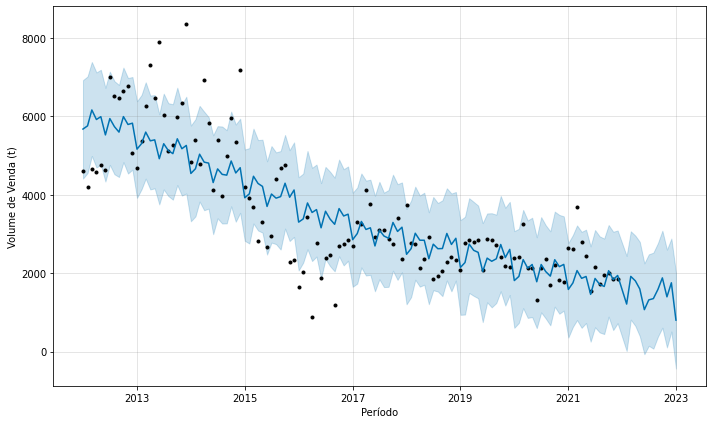

In [56]:
for market_values_df, market_name in zip(markets_values, markets_names):
    market_values_df_copy = market_values_df

    market_values_df_copy['Data'] = market_values_df_copy.index
    cols = market_values_df_copy.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    market_values_df_copy = market_values_df_copy[cols].reset_index(drop=True)
    market_values_df_copy.rename(columns = {'Data':'ds',market_name:'y'}, inplace = True)

    model = Prophet()
    model.fit(market_values_df_copy)

    future = model.make_future_dataframe(periods=13, freq ='M')
    if market_name != 'AL':
        future.drop(future.index[future['ds'] == '2021-12-31'], inplace=True)
    else:
        future.drop(future.index[future['ds'] == '2015-12-31'], inplace=True)

    forecast = model.predict(future)

    print(market_name)
    fig = model.plot(forecast, xlabel='Período',ylabel='Volume de Venda (t)')
    # ax = fig.gca()
    plt.show()
    
